<h1>Load the Data</h1>

In [41]:
#importing all the libraries
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

import tensorflow as tf
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GRU
from matplotlib import pyplot
from pickle import load

import time
from tensorflow.keras.layers import Dense, Flatten, Conv1D, LeakyReLU
from tensorflow.keras import Sequential

import pandas_profiling as pp
from matplotlib import style

In [42]:
df = pd.read_csv('result.csv.xls')
df.columns

Index(['Unnamed: 0', 'DATE', 'HEADLINE', 'TICKER', 'COMPANY NAME', 'SECTOR',
       'SERIES', 'DATE OF LISTING', 'PAID UP VALUE', 'MARKET LOT',
       'ISIN NUMBER', 'FACE VALUE', 'high', 'low', 'open', 'close', 'volume',
       'adj close', 'avg high', 'avg low', 'avg open', 'avg close',
       'avg volume', 'avg adj close', 'compound', 'negative_score',
       'positive_score', 'neutral_score', 'trend'],
      dtype='object')

<h1>Data Visualization</h1>

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

c:\Users\rowle\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


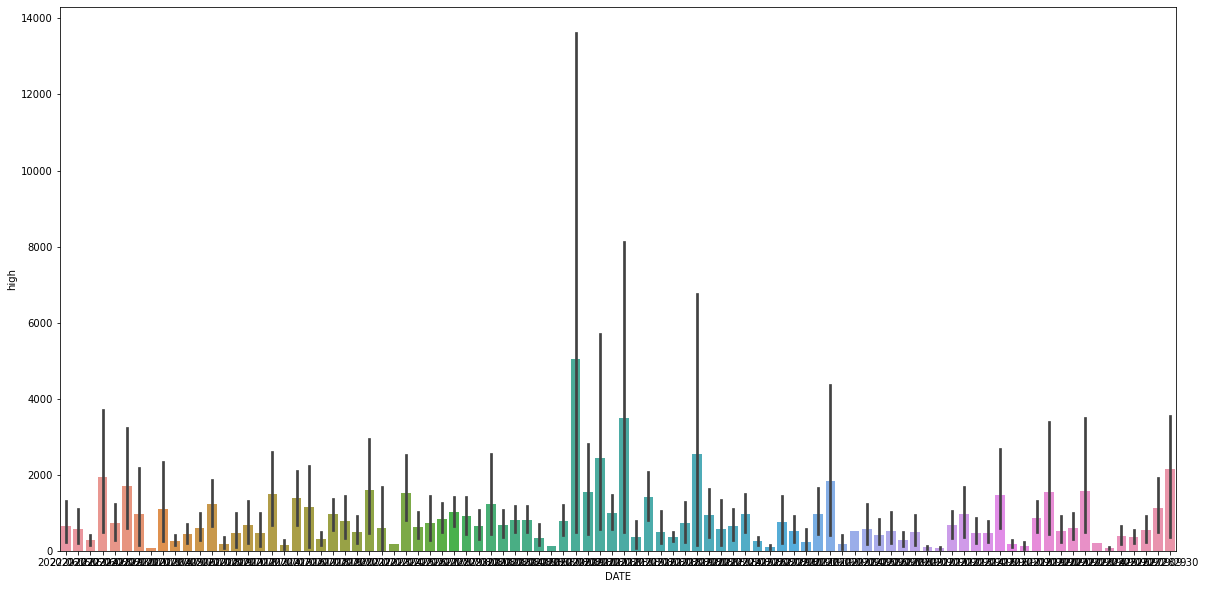

c:\Users\rowle\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


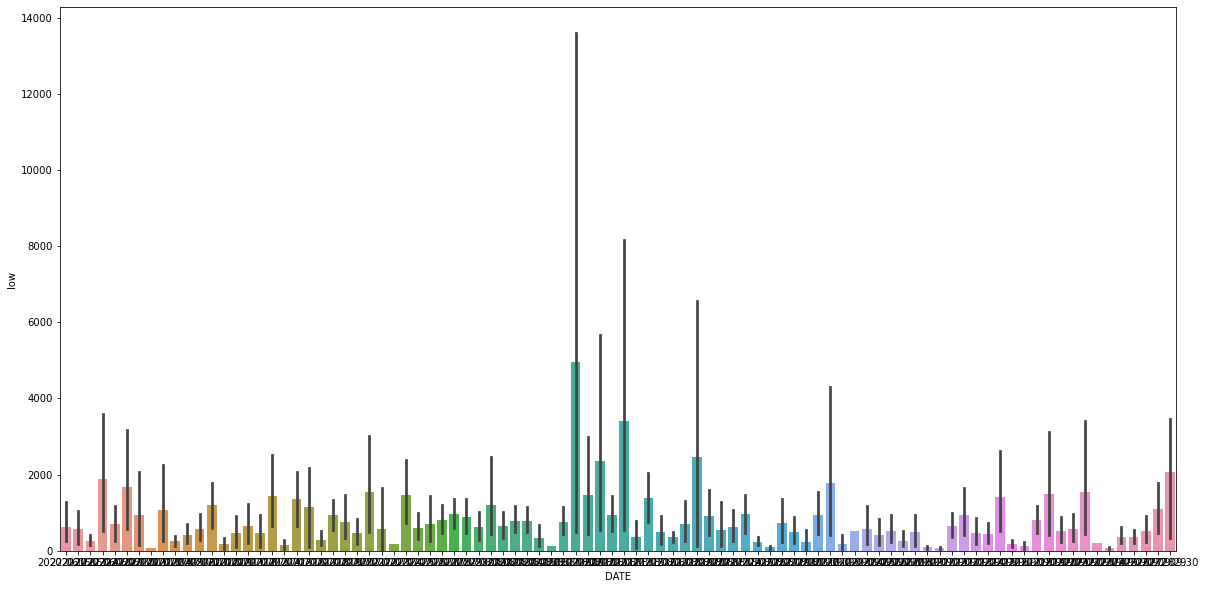

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def barPlotLow(x,y):
    plt.figure(figsize=(20,10))
    sns.barplot(df.DATE,df.low)
    plt.show()
def barPlotHigh(x,y):
    plt.figure(figsize=(20,10))
    sns.barplot(df.DATE,df.high)
    plt.show()

barPlotHigh(df.DATE,df.high)
barPlotLow(df.DATE,df.low)

<h1>Data Preprocessing</h1>

In [45]:
X_value = df[['high', 'open', 'close', 'volume','adj close', 'avg high', 'avg low', 'avg open', 'avg close','avg volume', 'avg adj close']]
y_value = df[['low']]

In [46]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

MinMaxScaler(feature_range=(-1, 1))

In [47]:
X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)
dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

In [48]:
# Reshape the data
#Set the data input steps and output steps,we use 30 days data to predict 1 day price here
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

In [49]:
# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

In [50]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):
    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [51]:
# Split the train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [52]:
# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(df, X_train, n_steps_in, n_steps_out)


In [53]:
#saving dataset into multiple files for ease of use
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)

X shape:  (1490, 3, 11)
y shape:  (1490, 1)
X_train shape:  (1043, 3, 11)
y_train shape:  (1043, 1)
y_c_train shape:  (1043, 3, 1)
X_test shape:  (447, 3, 11)
y_test shape:  (447, 1)
y_c_test shape:  (447, 3, 1)
index_train shape: (1043,)
index_test shape: (447,)


In [54]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

<h1>Using GAN and Bidirectional LSTM</h1>

In [55]:
from keras.layers import LSTM,Bidirectional
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add((LSTM(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),recurrent_dropout=0.2)))
    model.add((LSTM(units=512, return_sequences = True, recurrent_dropout=0.2)))
    model.add((LSTM(units=256, recurrent_dropout=0.2)))
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(units=output_dim))
    return model

In [56]:
def make_discriminator_model():
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net


model = make_discriminator_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 32)             128       
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_8 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 220)               28160     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 220)               0         
                                                                 
 dense_10 (Dense)            (None, 220)              

In [57]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,discriminator_optimizer=self.discriminator_optimizer,generator=self.generator,discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

c:\Users\rowle\anaconda3\lib\site-packages\keras\backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


epoch 15 d_loss 1.1378343 g_loss 1.1022853


epoch 30 d_loss 1.347751 g_loss 0.73151696


epoch 45 d_loss 1.344497 g_loss 0.7491127


epoch 60 d_loss 1.3733221 g_loss 0.6942254


epoch 75 d_loss 1.3657696 g_loss 0.7004842


epoch 90 d_loss 1.3831995 g_loss 0.67770684


epoch 105 d_loss 1.3658206 g_loss 0.69924396


epoch 120 d_loss 1.3895699 g_loss 0.71909


epoch 135 d_loss 1.389253 g_loss 0.69738346


epoch 150 d_loss 1.3878703 g_loss 0.6918654


epoch 165 d_loss 1.3864774 g_loss 0.6746757


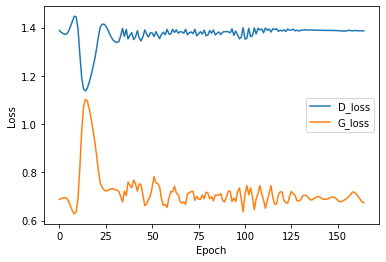

In [58]:
if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [59]:
# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))

train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

In [60]:
print("----- predicted price -----", Predicted_price) 

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

----- predicted price ----- [[-0.93139154]
 [-0.9292765 ]
 [-0.929909  ]
 ...
 [-0.9303085 ]
 [-0.93284833]
 [-0.9312221 ]]
----- rescaled predicted price ----- [[3002.145 ]
 [3094.6763]
 [3067.006 ]
 ...
 [3049.5266]
 [2938.4104]
 [3009.5586]]
----- SHAPE rescaled predicted price ----- (1043, 1)


In [61]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
#
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)


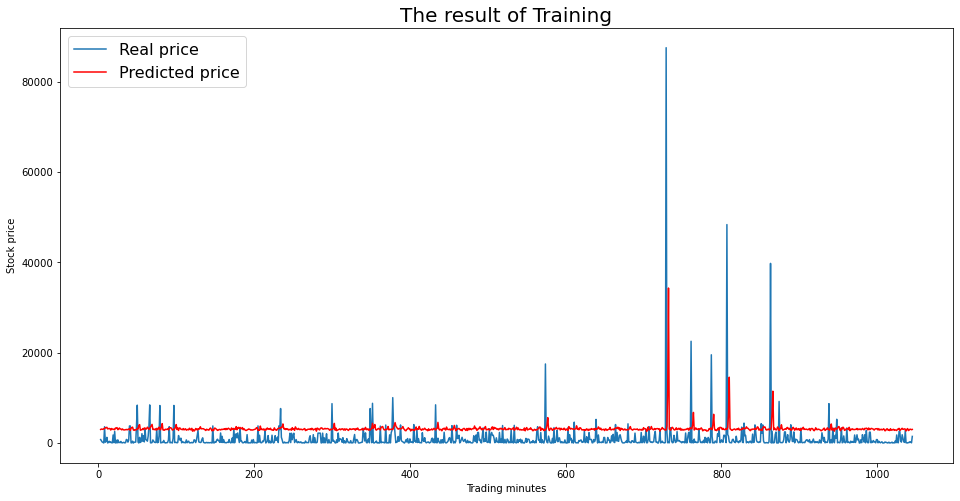

In [62]:
# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Trading minutes")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

In [63]:
# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

-- Train RMSE --  4441.7396576657775


In [64]:
# Load test dataset/ model
G_model = tf.keras.models.load_model('gen_model_3_1_164.h5')
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [65]:
def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = G_model(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Trading Minutes")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

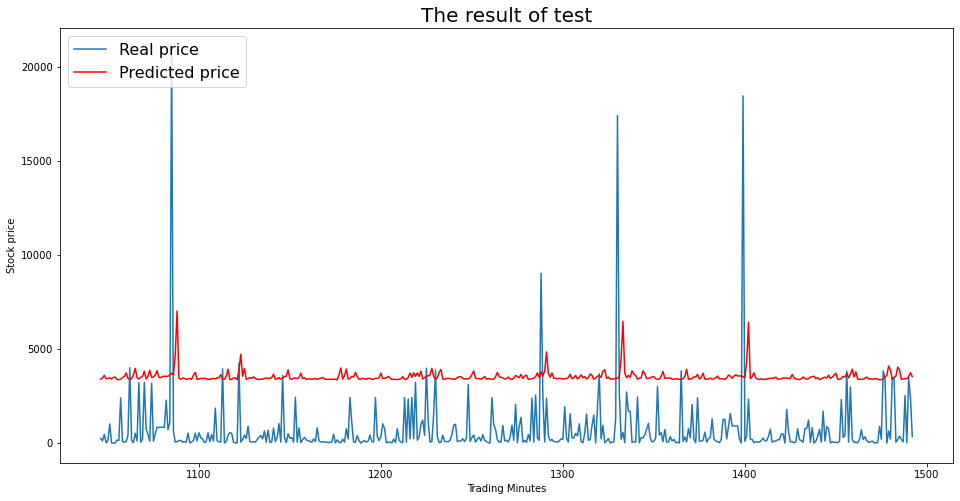

-- RMSE --  3342.164945457742


<Figure size 432x288 with 0 Axes>

In [66]:
test_predicted, test_RMSE = get_test_plot(X_test, y_test)
test_predicted.to_csv("test_predicted.csv")

In [67]:
X_test[0][0]

array([-0.99529521, -0.9952007 , -0.99529904, -0.99907114, -0.99529904,
       -0.9954342 , -0.99555827, -0.99555358, -0.99670926, -0.99670926,
       -0.99548904])

In [68]:
predicted = np.array(predict_result)
real_d = np.array(real_price)

#array of prices of predicted and actual values
pred_price = []
real_pr = []

for i in range(len(predicted)):
    pred_price.append(predicted[i][i])
    real_pr.append(real_d[i][i])

actual_trend=[]
predicted_trend=[]

In [69]:
for i in range(1,len(pred_price)):
    if(pred_price[i]>real_pr[i-1]):
        predicted_trend.append("bullish")
    else:
        predicted_trend.append("bearish")
    if(real_pr[i]>real_pr[i-1]):
        actual_trend.append("bullish")
    else:
        actual_trend.append("bearish")

In [70]:
count = 0
for i in range(len(actual_trend)):
    if(actual_trend[i]==predicted_trend[i]):
        count=count+1

In [71]:
print("Model Accuracy: ", count/len(actual_trend)*100)

Model Accuracy:  52.49520153550864
